In [1]:
%run 'data_preparation.ipynb'

In [2]:
from fbprophet import Prophet

In [90]:
year.tail()

,BOOKING_HAL_ID,CATEGORY_HAL_ID,VEHICLE_HAL_ID,CUSTOMER_HAL_ID,DATE_BOOKING,DATE_FROM,DATE_UNTIL,COMPUTE_EXTRA_BOOKING_FEE,TRAVERSE_USE,DISTANCE,...,BOOKING_DATE,FROM_DATE,BOOKING_YEAR,BOOKING_MONTH,BOOKING_WDAY,BOOKING_QUARTER,FROM_MONTH,UNTIL_MONTH,FROM_WDAY,UNTIL_WDAY
542932,43060293,100005,161830,FBFBE66F79A8407BF2DA061EB035A9E3BA60FB5C,2016-11-30 11:29:24,2016-11-30 09:05:46,2016-11-30 10:48:14,Nein,Nein,26,...,2016-11-30,2016-11-30,2016,11,2,4,11,11,2,2
542933,43070512,100005,161830,FBFBE66F79A8407BF2DA061EB035A9E3BA60FB5C,2016-11-30 21:22:43,2016-11-30 19:04:47,2016-11-30 21:20:02,Nein,Nein,57,...,2016-11-30,2016-11-30,2016,11,2,4,11,11,2,2
542934,43079191,100005,161830,FBFBE66F79A8407BF2DA061EB035A9E3BA60FB5C,2016-12-01 11:53:11,2016-12-01 09:10:44,2016-12-01 11:31:47,Nein,Nein,36,...,2016-12-01,2016-12-01,2016,12,3,4,12,12,3,3
542935,43087847,100005,161830,FBFBE66F79A8407BF2DA061EB035A9E3BA60FB5C,2016-12-01 19:59:15,2016-12-01 18:11:49,2016-12-01 19:58:13,Nein,Nein,34,...,2016-12-01,2016-12-01,2016,12,3,4,12,12,3,3
542936,43097826,100005,161830,FBFBE66F79A8407BF2DA061EB035A9E3BA60FB5C,2016-12-02 11:02:44,2016-12-02 09:06:58,2016-12-02 11:01:21,Nein,Nein,18,...,2016-12-02,2016-12-02,2016,12,4,4,12,12,4,4


In [91]:
per_day = year.pivot_table(index=['BOOKING_DATE'],values=['BOOKING_HAL_ID'], aggfunc=lambda x: len(x.unique()))

In [92]:
per_day.reset_index(inplace=True)
per_day.tail()

,BOOKING_DATE,BOOKING_HAL_ID
1091,2016-12-27,273
1092,2016-12-28,263
1093,2016-12-29,301
1094,2016-12-30,315
1095,2016-12-31,225


# Prediction with out holiday data

In [93]:
# Prophet requires columns ds (Date) and y (value)
per_day = per_day.rename(columns={'BOOKING_DATE': 'ds', 'BOOKING_HAL_ID': 'y'})
# Make the prophet model and fit on the data
per_day_prophet = Prophet(changepoint_prior_scale=0.15)
per_day_prophet.fit(per_day)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [94]:
# Make a future dataframe for 2 years
per_day_forecast = per_day_prophet.make_future_dataframe(periods=730, freq='D')
# Make predictions
per_day_forecast = per_day_prophet.predict(per_day_forecast)

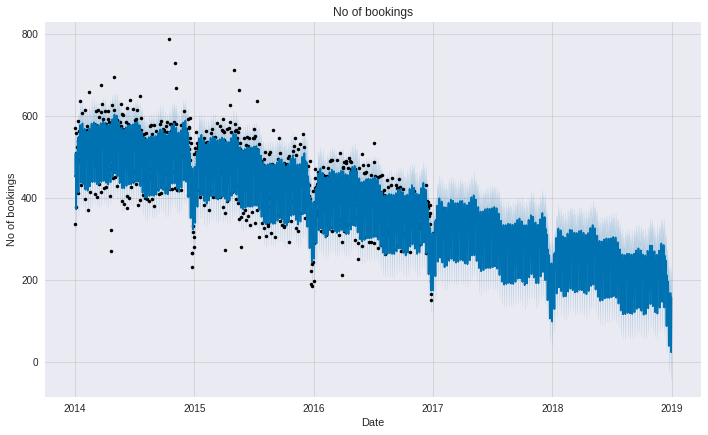

In [95]:
per_day_prophet.plot(per_day_forecast, xlabel = 'Date', ylabel = 'No of bookings')
plt.title('No of bookings');

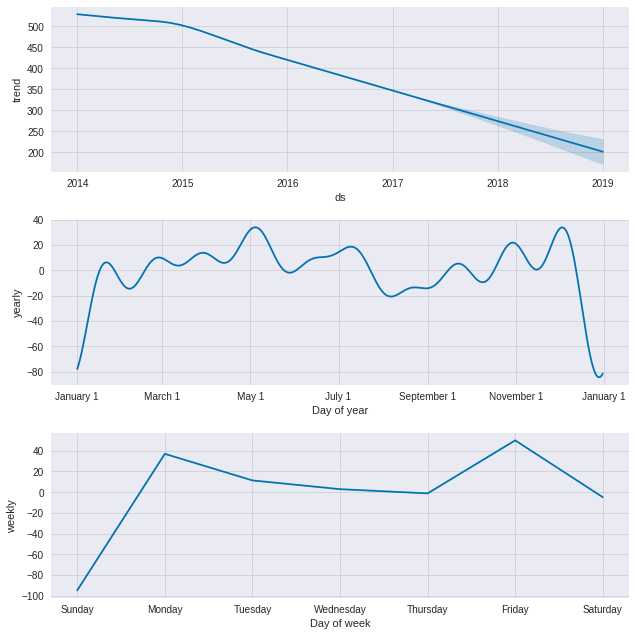

In [96]:
per_day_prophet.plot_components(per_day_forecast);

# Effect of Changepoint Prior Scale

In [97]:
# Try 4 different changepoints
for changepoint in [0.001, 0.02, 0.03, 0.04]:
    model = Prophet(daily_seasonality=False, changepoint_prior_scale=changepoint)
    model.fit(per_day)
    
    future = model.make_future_dataframe(periods=12, freq='M')
    future = model.predict(future)
    
    per_day[changepoint] = future['yhat']

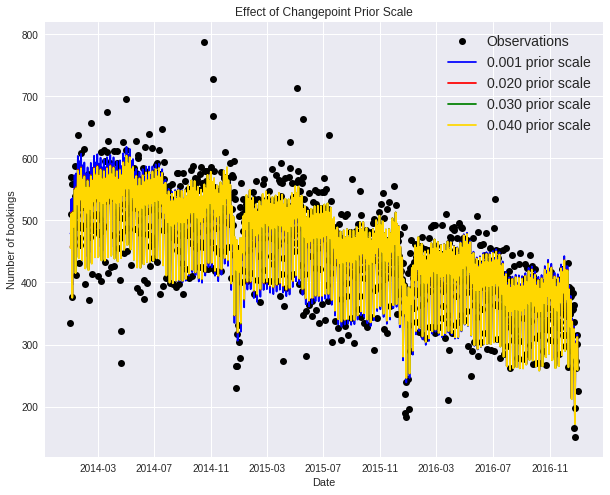

In [98]:
plt.figure(figsize=(10, 8))

# Actual observations
plt.plot(per_day['ds'], per_day['y'], 'ko', label = 'Observations')
colors = {0.001: 'b', 0.02: 'r', 0.03: 'green', 0.04: 'gold'}

# Plot each of the changepoint predictions
for changepoint in [0.001, 0.02, 0.03, 0.04]:
    plt.plot(per_day['ds'], per_day[changepoint], color = colors[changepoint], label = '%.3f prior scale' % changepoint)
    
plt.legend(prop={'size': 14})
plt.xlabel('Date'); plt.ylabel('Number of bookings'); plt.title('Effect of Changepoint Prior Scale');


# Prediction with holiday data

In [99]:
promotions = pd.DataFrame({
  'holiday': holidays.PUBLIC_HOLIDAYS,
  'ds': holidays.BOOKING_DATE,
  'lower_window': 0,
  'upper_window': 0,
})

In [100]:
promotions.head()

,ds,holiday,lower_window,upper_window
0,01-01-2019,New Year's Day,0,0
1,30-03-2019,Good Friday,0,0
2,02-04-2019,Easter Monday,0,0
3,01-05-2019,Labour Day,0,0
4,10-05-2019,Ascension Day,0,0


In [101]:
model = Prophet(holidays=promotions)

In [102]:
model.fit(per_day)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [103]:
future = model.make_future_dataframe(periods=730, freq = 'D')
future.tail()

,ds
1821,2018-12-27
1822,2018-12-28
1823,2018-12-29
1824,2018-12-30
1825,2018-12-31


In [104]:
forecast = model.predict(future)

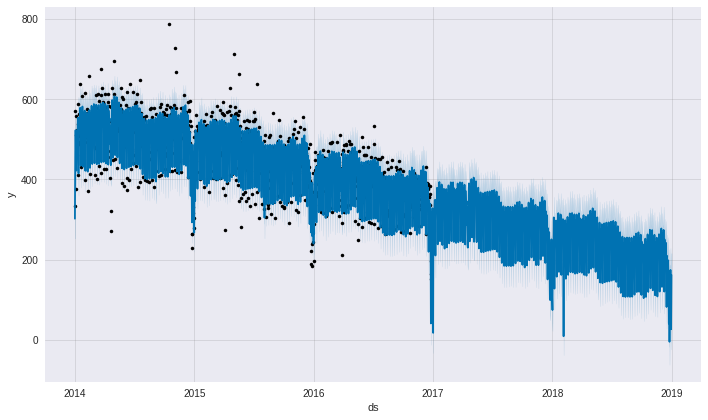

In [105]:
model.plot(forecast);

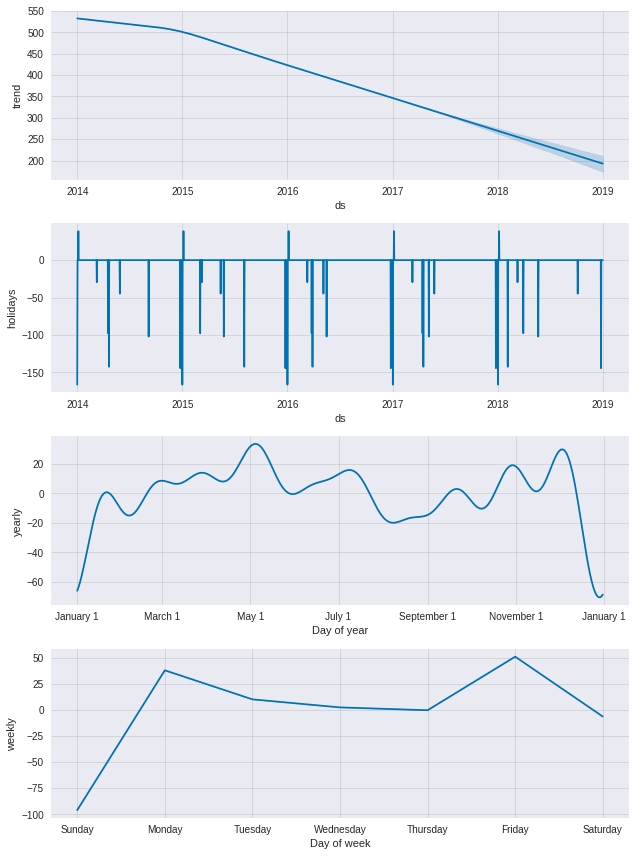

In [106]:
model.plot_components(forecast);

# Difference between holiday and non-holiday

In [107]:
forecast.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,Ascension Day,Ascension Day_lower,Ascension Day_upper,Christmas Day,...,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
1821,2018-12-27,193.625311,174.392307,211.937181,65.642043,180.619613,0.0,0.0,0.0,0.0,...,-69.126693,-69.126693,-69.126693,-0.134404,-0.134404,-0.134404,-68.992290,-68.992290,-68.992290,124.498618
1822,2018-12-28,193.415031,174.177918,211.777596,117.268502,229.433205,0.0,0.0,0.0,0.0,...,-18.843700,-18.843700,-18.843700,51.268290,51.268290,51.268290,-70.111990,-70.111990,-70.111990,174.571331
1823,2018-12-29,193.204751,173.963530,211.618011,61.100859,169.638598,0.0,0.0,0.0,0.0,...,-76.641056,-76.641056,-76.641056,-6.173558,-6.173558,-6.173558,-70.467497,-70.467497,-70.467497,116.563695
1824,2018-12-30,192.994471,173.749142,211.458426,-23.584230,82.880561,0.0,0.0,0.0,0.0,...,-166.096202,-166.096202,-166.096202,-96.028519,-96.028519,-96.028519,-70.067683,-70.067683,-70.067683,26.898269
1825,2018-12-31,192.784191,173.494708,211.298841,107.190262,216.505572,0.0,0.0,0.0,0.0,...,-30.754429,-30.754429,-30.754429,38.181637,38.181637,38.181637,-68.936065,-68.936065,-68.936065,162.029762


In [108]:
forecast.set_index('ds', inplace=True)
per_day_forecast.set_index('ds', inplace=True)
compared_df = forecast.join(per_day_forecast, rsuffix="_no_holiday")

In [109]:
compared_df = compared_df[['yhat', 'yhat_no_holiday']]

In [110]:
compared_df.head()

,yhat,yhat_no_holiday
ds,,
2014-01-01,302.263656,452.224083
2014-01-02,468.405564,451.579120
2014-01-03,522.919481,506.885894
2014-01-04,469.078723,456.713711
2014-01-05,421.946482,371.958197


In [111]:
compared_df.reset_index(inplace=True)

In [112]:
compared_dfexp= np.exp(compared_df[['yhat', 'yhat_no_holiday']])

In [113]:
compared_dfexp['diff_per'] = 100*(compared_dfexp['yhat'] - compared_dfexp['yhat_no_holiday']) / compared_dfexp['yhat_no_holiday']

In [114]:
compared_dfexp.tail()

,yhat,yhat_no_holiday,diff_per
1821,1.172365e+54,1.343293e+51,87175.409391
1822,6.536809e+75,6.291013e+72,103807.104690
1823,4.197297e+50,6.473596e+48,6383.718641
1824,4.805847e+11,9.876644e+09,4765.870403
1825,2.336855e+70,7.533308e+67,30920.301253


In [115]:
compared_dfexp['diff_per'].mean()

5.7167477202550424e+20

In [116]:
final_df= compared_df[['yhat', 'yhat_no_holiday']]

In [117]:
final_df.reset_index(inplace=True)

In [118]:
final_df.head()

,index,yhat,yhat_no_holiday
0,0,302.263656,452.224083
1,1,468.405564,451.579120
2,2,522.919481,506.885894
3,3,469.078723,456.713711
4,4,421.946482,371.958197


In [119]:
per_day.head()

,ds,y,0.001,0.02,0.03,0.04
0,2014-01-01,335,479.108520,458.363604,456.807389,455.923934
1,2014-01-02,570,478.160399,457.559374,456.029374,455.162148
2,2014-01-03,510,534.370918,512.667084,511.204413,510.354006
3,2014-01-04,558,482.847921,462.380432,460.905662,460.069923
4,2014-01-05,377,396.000565,377.514305,376.014699,375.192235


In [120]:
result_df = per_day.join(final_df, rsuffix="del")

In [121]:
result_df = result_df.rename(columns={'ds':'BOOKING_DATE','y':'BOOKING_HAL_ID'})

In [122]:
cols = [3,4]
result_df = result_df.drop(result_df.columns[cols], axis=1)

In [123]:
cols = [2,3,4]
result_df = result_df.drop(result_df.columns[cols], axis=1)

In [124]:
cols = ['yhat', 'yhat_no_holiday']
result_df[cols] = result_df[cols].applymap(np.int64)

In [125]:
result_df.head(10)

,BOOKING_DATE,BOOKING_HAL_ID,yhat,yhat_no_holiday
0,2014-01-01,335,302,452
1,2014-01-02,570,468,451
2,2014-01-03,510,522,506
3,2014-01-04,558,469,456
4,2014-01-05,377,421,371
5,2014-01-06,524,521,509
6,2014-01-07,509,498,489
7,2014-01-08,507,495,487
8,2014-01-09,510,497,489
9,2014-01-10,588,553,546


In [128]:
trace0 = go.Scatter(
    x = result_df.BOOKING_DATE,
    y = result_df.BOOKING_HAL_ID,
    mode = 'lines',
    name = 'actual number of bookings'
)
trace1 = go.Scatter(
    x = result_df.BOOKING_DATE,
    y = result_df.yhat,
    mode = 'lines',
    name = 'number of bookings with holiday data'
)
trace2 = go.Scatter(
    x = result_df.BOOKING_DATE,
    y = result_df.yhat_no_holiday,
    mode = 'lines',
    name = 'number of bookings with out holiday data'
)
layout = go.Layout(title="observations from FbProphet model",
                yaxis=dict(title='number of bookings')
                )
fig = go.Figure(data=[trace0, trace1, trace2], layout=layout)
py.iplot(fig, filename="Observations from FbProphet")

In [129]:
trace0 = go.Scatter(
    x = result_df.BOOKING_DATE,
    y = result_df.BOOKING_HAL_ID,
    mode = 'lines',
    name = 'actual number of bookings'
)
trace1 = go.Scatter(
    x = compared_df.ds,
    y = compared_df.yhat,
    mode = 'lines',
    name = 'number of bookings with holiday data'
)
trace2 = go.Scatter(
    x = compared_df.ds,
    y = compared_df.yhat_no_holiday,
    mode = 'lines',
    name = 'number of bookings with out holiday data'
)
layout = go.Layout(title="observations from FbProphet model with next 2 years prediction",
                yaxis=dict(title='number of bookings')
                )
fig = go.Figure(data=[trace0, trace1, trace2], layout=layout)
py.iplot(fig, filename="Observations from FbProphet")